# Time Series Analyses of Leafy Spurge with Linear Regression

This notebook performs linear regression on time-series raster pixel values. We perform a linear regression on the pixel values over time to estimate the slope of the trendline, which indicates the overall direction and rate of change in predicted leafy spurge populations.

Linear regression models the relationship between two variables by fitting a straight line through the data points. In the case of change detection, the independent variable is time, and the dependent variable is the pixel value. The slope of the fitted line represents the rate of change over time. A positive slope indicates an increase in the pixel value, while a negative slope indicates a decrease.

These analyses are designed to support the time-series analyses of invasive species leafy spurge using multi-date Landsat satellite image remote sensing.

Author: Thomas A. Lake
Date: Jan 2024


# Python General Packages & Imports

In [1]:

#Time series analyses of each pixel in stacked rasters
import os
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show
import glob
import time
import itertools
from scipy import stats
from skimage.measure import block_reduce
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Prepare data for a time-series regressions on large .tif files are performed in a parallel Python environment

Note: Depending on the extent of pixel downsampling (mean aggregation) with the block_reduce function, these analyses may have high RAM memory requirements.

In [ ]:

# Load predictions of leafy spurge from 2000 to 2019, then run linear regressions on each pixel as proability ~ time.

# Define array to hold prediction rasters
years_list = [0, 1, 2, 3, 4, 5, 6]
years_array = np.array(years_list)
years_array = years_array.reshape((1, years_array.shape[0]))

# Define ordered list of .tif files for analyses
ordered_files =  ['/home/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/minnesota_merged_landsat_tiles/mn_landsat_2001_merged.tif',
                  '/home/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/minnesota_merged_landsat_tiles/mn_landsat_2004_merged.tif',
                  '/home/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/minnesota_merged_landsat_tiles/mn_landsat_2007_merged.tif',
                  '/home/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/minnesota_merged_landsat_tiles/mn_landsat_2010_merged.tif',
                  '/home/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/minnesota_merged_landsat_tiles/mn_landsat_2014_merged.tif',
                  '/home/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/minnesota_merged_landsat_tiles/mn_landsat_2016_merged.tif',
                  '/home/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/minnesota_merged_landsat_tiles/mn_landsat_2019_merged.tif']


# Define the original raster shape
n_rows = 25980
n_cols = 33396

# Create a placeholder array of zeros
base_array = np.zeros((n_rows, n_cols * len(ordered_files)))

# Concatenate array data from multiple files
for i, each_file in enumerate(ordered_files):
    year = years_list[i]

    # Open the file, read in as an array
    with rio.open(each_file) as src:
        arr = src.read(1)
        shp = arr.shape
        print(shp)
        
        # Pad the array with zeros if arrays are of different shape
        if shp != (n_rows, n_cols):
            pad_rows = n_rows - shp[0]
            pad_cols = n_cols - shp[1]
            arr = np.pad(arr, ((0, pad_rows), (0, pad_cols)), mode='constant')
            print("Padded array with 0's", arr.shape)
        
        # Downsample the raster by averaging over blocks of size 10x10 pixels
        # This is needed to reduce memory footprint for linear regression on all Landsat pixels in MN
        arr = block_reduce(arr, block_size=(10, 10), func=np.mean)
        shp = arr.shape
        print(shp)
        
        # Flatten the 2D array
        arr_flat = arr.reshape((shp[0] * shp[1], 1))

        # For the very first array, use it as the base, then concatenate (stack) prediction rasters on it
        if i == 0:
            base_array =  arr_flat
            continue  # skip to the next year

        # Stack the arrays from each year
        base_array = np.concatenate((base_array,  arr_flat), axis=1)
        print(base_array.shape)

        
# Create an array for the X variable, or independent variable, i.e., the year
shp = base_array.shape
years_array = np.repeat(years_array, shp[0], axis = 0).reshape((shp[0], shp[1], 1))
base_array = base_array.reshape((shp[0], shp[1], 1))

# Now, combine X and Y data
base_array = np.concatenate((years_array, base_array), axis = 2)

print(base_array.shape) # shape (pixels, timesteps, 2), where last axis contains year and Landsat data

print("Predictor Stacking Finished")



(25980, 33396)
(2598, 3340)
(25980, 33396)
(2598, 3340)
(8677320, 2)
(25980, 33396)
(2598, 3340)
(8677320, 3)
(25980, 33396)
(2598, 3340)
(8677320, 4)
(25980, 33396)
(2598, 3340)
(8677320, 5)
(25980, 33396)
(2598, 3340)
(8677320, 6)


(86840, 7, 2)


Text(0.5, 1.0, 'Prediction Year 1')

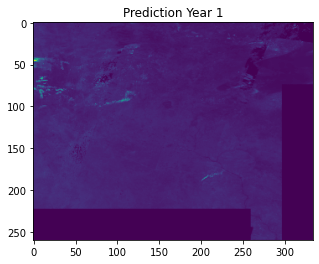

Text(0.5, 1.0, 'Prediction Year 2')

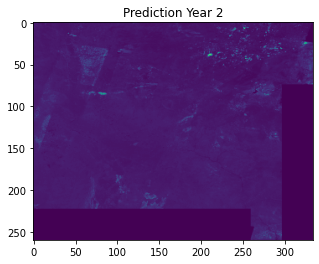

Text(0.5, 1.0, 'Prediction Year 3')

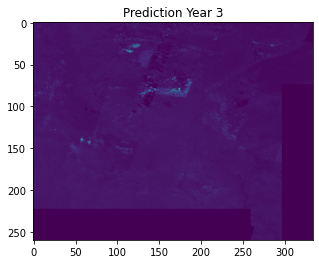

Text(0.5, 1.0, 'Prediction Year 4')

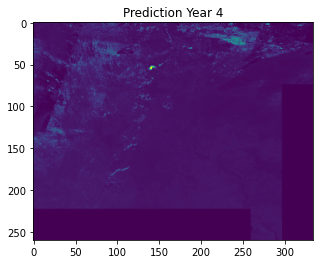

Text(0.5, 1.0, 'Prediction Year 5')

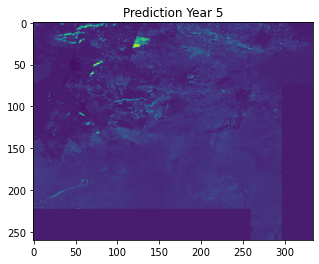

Text(0.5, 1.0, 'Prediction Year 6')

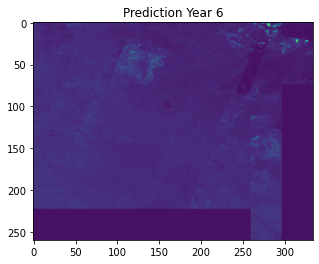

Text(0.5, 1.0, 'Prediction Year 7')

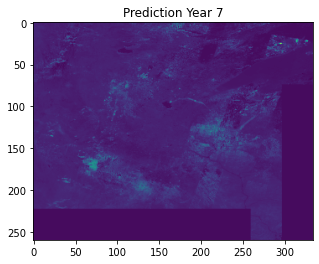

In [4]:

print(base_array.shape)

# Reshape and plot each time-step prediction
for i in range(base_array.shape[1]):
    # Reshape the band into (446, 1151)
    band = base_array[:, i, 1].reshape((260, 334))

    # Plot the band
    plt.imshow(band)
    plt.title(f"Prediction Year {i+1}")
    plt.show()




# Reshape data for use in a linear model

# Transform data for discrete population model based on ln(Nt+1/Nt) ~ a + b* Nt as presented in  https://doi.org/10.1111/ecog.00836

In [6]:
#Flattened base_array
print(base_array.shape) # (samples, 10, 2)

#Reshape base array to dimensions of image
base_array_reshape = base_array.reshape((260, 334, 7, 2)) #raster dim, 10 timestep rasters; year and data variables

# Create the year_intervals variable
year_intervals = list(range(0, 6)) # number of intervals between year rasters (10 rasters, 9 intervals)
year_intervals_array = np.array(year_intervals)

print(year_intervals_array)


base_array[1, :, 0] #years
base_array[1, :, 1] #predictions

# Calculate the difference between consecutive predictions
prediction_diff = np.diff(base_array[:, :, 1], axis=1)

#prediction_diff

# Calculate the ratio between consecutive predictions
prediction_ratio = np.divide(base_array[:, 1:, 1], base_array[:, :-1, 1])

#prediction_ratio

# Now, calculate logarithm of the ratio between two consecutive predictions
prediction_ratio_log = np.log(prediction_ratio) # Log transform "Observations" Nt

# Replace nan values with 0
prediction_ratio_log = np.nan_to_num(prediction_ratio_log, nan=0.0)

# Define your threshold for outliers, 
threshold = 10.0

# Identify and remove outliers
prediction_ratio_log_cleaned = np.where(np.abs(prediction_ratio_log) > threshold, 0, prediction_ratio_log)

prediction_ratio_log_cleaned.shape


(86840, 7, 2)
[0 1 2 3 4 5]


array([0., 1., 2., 3., 4., 5., 6.])

array([865.0666, 743.4611, 652.1031, 483.5657, 671.8945, 719.0148,
       712.9463])

/tmp/ipykernel_474761/1554521829.py:23: RuntimeWarning: divide by zero encountered in true_divide
  prediction_ratio = np.divide(base_array[:, 1:, 1], base_array[:, :-1, 1])
/tmp/ipykernel_474761/1554521829.py:23: RuntimeWarning: invalid value encountered in true_divide
  prediction_ratio = np.divide(base_array[:, 1:, 1], base_array[:, :-1, 1])
/tmp/ipykernel_474761/1554521829.py:28: RuntimeWarning: divide by zero encountered in log
  prediction_ratio_log = np.log(prediction_ratio) # Log transform "Observations" Nt
/tmp/ipykernel_474761/1554521829.py:28: RuntimeWarning: invalid value encountered in log
  prediction_ratio_log = np.log(prediction_ratio) # Log transform "Observations" Nt


(86840, 6)

(array([2.10000e+01, 2.90000e+01, 3.80000e+01, 4.60000e+01, 9.00000e+01,
        1.00000e+02, 1.09000e+02, 1.38000e+02, 1.78000e+02, 2.58000e+02,
        2.84000e+02, 3.66000e+02, 4.05000e+02, 5.47000e+02, 6.59000e+02,
        8.13000e+02, 9.45000e+02, 1.27300e+03, 1.79700e+03, 2.58900e+03,
        3.84500e+03, 6.33700e+03, 1.28430e+04, 3.11860e+04, 2.44521e+05,
        1.39462e+05, 3.70560e+04, 1.59530e+04, 7.45600e+03, 3.62000e+03,
        1.95400e+03, 1.25200e+03, 9.23000e+02, 7.54000e+02, 6.00000e+02,
        4.94000e+02, 4.01000e+02, 3.37000e+02, 2.84000e+02, 2.22000e+02,
        1.88000e+02, 1.67000e+02, 1.46000e+02, 1.03000e+02, 8.80000e+01,
        7.00000e+01, 3.90000e+01, 2.50000e+01, 1.70000e+01, 1.20000e+01]),
 array([-9.98105105e+00, -9.58145000e+00, -9.18184895e+00, -8.78224790e+00,
        -8.38264686e+00, -7.98304581e+00, -7.58344476e+00, -7.18384371e+00,
        -6.78424267e+00, -6.38464162e+00, -5.98504057e+00, -5.58543952e+00,
        -5.18583847e+00, -4.78623743e+00

Text(0.5, 0, 'Log Ratio')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Log Ratio')

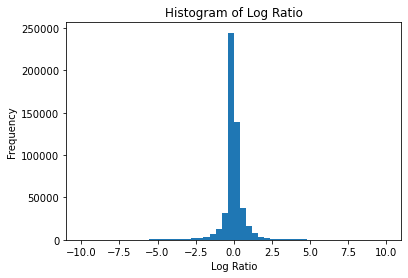

In [7]:
import matplotlib.pyplot as plt


plt.hist(prediction_ratio_log_cleaned.flatten(), bins=50)
plt.xlabel('Log Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Log Ratio')
plt.show()


[-0.08673556 -0.03408672 -0.75765121  0.84413745  0.15255524 -0.50204278]


Text(0.5, 1.0, 'Prediction Log Ratio: Year 1')

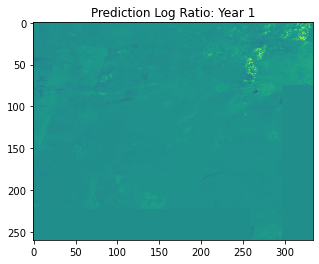

Text(0.5, 1.0, 'Prediction Log Ratio: Year 2')

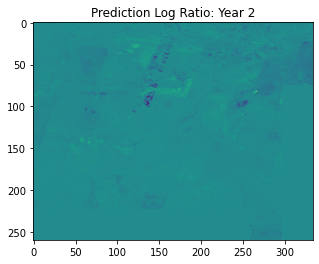

Text(0.5, 1.0, 'Prediction Log Ratio: Year 3')

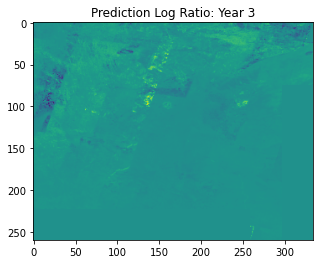

Text(0.5, 1.0, 'Prediction Log Ratio: Year 4')

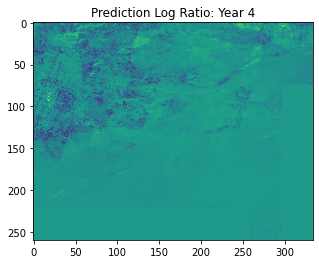

Text(0.5, 1.0, 'Prediction Log Ratio: Year 5')

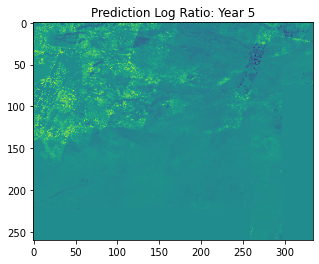

Text(0.5, 1.0, 'Prediction Log Ratio: Year 6')

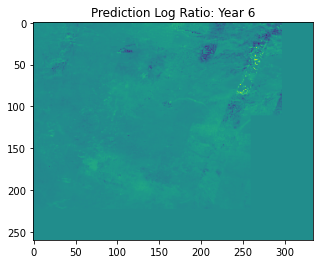

In [8]:
reshaped_prediction_ratio_log_cleaned = prediction_ratio_log_cleaned.reshape(260, 334, 6)

print(reshaped_prediction_ratio_log_cleaned[0, 0, ...])

# Plot the log-ratios between each time-step
for i in range(reshaped_prediction_ratio_log_cleaned.shape[2]):
    # Plot the log-ratio
    plt.imshow(reshaped_prediction_ratio_log_cleaned[..., i])
    plt.title(f"Prediction Log Ratio: Year {i+1}")
    plt.show()




# Perform a single linear model on one pixel from the base_array X (time) predictors and y (predicted leafy spurge)

Y-predicted: [-0.0676211]
Intercept: -0.0700547662608525
Slope: 0.002433668192516822
Carrying Capacity: 28.785668677538204


Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 0): y = 0.00x + -0.07; GR = 0.93')

FileNotFoundError: [Errno 2] No such file or directory: '/home/moeller/shared/leafy-spurge-demography/model_predictions/spurge_mosaic_predictions_gapcorrected_july2023/ricker_model_linear_regression_plots_pixels/log_ratio_predicted_spurge_timeseries_linearmodel_11km_resampled_westND_pixel_0_0.png'

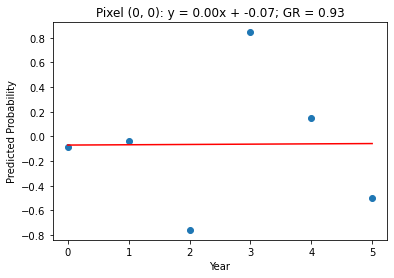

In [10]:
from sklearn.preprocessing import StandardScaler

output_directory = r'/home/moeller/shared/leafy-spurge-demography/model_predictions/spurge_mosaic_predictions_gapcorrected_july2023/ricker_model_linear_regression_plots_pixels'

N = base_array.shape[0]
#results = np.empty((N, 4)) # Create an empty results array with the same shape as base_array
intercepts = []
slopes = []
growths = []
capacities = []
r_squared_values = []
b_values = []

#for i in range(10000):
#for i in range(base_array_reshape.shape[0]):
#    for j in range(base_array_reshape.shape[1]):
for i in range(0, 2):
    for j in range(0, 4):
        #X = base_array_reshape[i, j, :, 0] # years
        #X = X.reshape((-1, 1))
        #y = base_array_reshape[i, j, :, 1] # predictions
        X = year_intervals_array.reshape((-1, 1)) # Years 0, 1, 2, 3, 4, 5, 6 ...
        y = prediction_ratio_log_cleaned.reshape(260, 334, 6) # log(Nt+1/Nt), Predictions [ 0.06950966 -0.03198007 -0.67717215  0.00872175 -0.13770668  0.70541865]
        y = y[i, j, ...]
        
        # Run linear model
        reg = LinearRegression().fit(X, y)
        # Infer Discrete Population Model Parameters R (Growth Rate) and K (Carrying Capacity) at Nt
        slope = reg.coef_[0]
        intercept = reg.intercept_    # parameter 'a'
        # Calculate growth rate and carrying capacity
        growth_rate = np.exp(intercept)  #intercept that measures density-independent recruitment (r)
        # To estimate K, we made a prediction from our equation at Nt=1 to extract the value of (a+b) and then subtract a to isolate b  

        # Calculate 'b' parameter
        X_pred = np.array([[1]])  # Predicting at Nt = 1
        y_pred = reg.predict(X_pred)
        print("Y-predicted:", y_pred)
        print("Intercept:", intercept)
        b = y_pred[0] - intercept
        print("Slope:", b)

        #Calculate carrying capacity
        carrying_capacity = -(intercept/b)
        print("Carrying Capacity:", carrying_capacity)

        # Store the results
        intercepts.append(intercept)
        slopes.append(slope)
        growths.append(growth_rate)
        capacities.append(carrying_capacity)
        b_values.append(b)

        # Calculate and store the R-squared value
        r_squared = reg.score(X, y)
        r_squared_values.append(r_squared)

        fig, ax = plt.subplots()
        ax.scatter(X, y)
        ax.plot(X, slope*X + intercept, color='red')
        ax.set_xlabel('Year')
        ax.set_ylabel('Predicted Probability')
        ax.set_title(f'Pixel ({i}, {j}): y = {slope:.2f}x + {intercept:.2f}; GR = {growth_rate:.2f}' )
        
        output_filename = os.path.join(output_directory, f'log_ratio_predicted_spurge_timeseries_linearmodel_11km_resampled_westND_pixel_{i}_{j}.png')
        plt.savefig(output_filename)  # Save the plot as a .png image

        plt.show()  # Display the plot before saving it

        plt.close(fig)  # Close the figure to free up memory


        




(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.43234276, 0.44234276, 0.45234276, 0.46234276, 0.47234276,
        0.48234276, 0.49234276, 0.50234276, 0.51234276, 0.52234276,
        0.53234276, 0.54234276, 0.55234276, 0.56234276, 0.57234276,
        0.58234276, 0.59234276, 0.60234276, 0.61234276, 0.62234276,
        0.63234276, 0.64234276, 0.65234276, 0.66234276, 0.67234276,
        0.68234276, 0.69234276, 0.70234276, 0.71234276, 0.72234276,
        0.73234276, 0.74234276, 0.75234276, 0.76234276, 0.77234276,
        0.78234276, 0.79234276, 0.80234276, 0.81234276, 0.82234276,
      

Text(0.5, 0, 'Growth Rate')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Growth Rates')

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.49756633, -0.48756633, -0.47756633, -0.46756633, -0.45756633,
        -0.44756633, -0.43756633, -0.42756633, -0.41756633, -0.40756633,
        -0.39756633, -0.38756633, -0.37756633, -0.36756633, -0.35756633,
        -0.34756633, -0.33756633, -0.32756633, -0.31756633, -0.30756633,
        -0.29756633, -0.28756633, -0.27756633, -0.26756633, -0.25756633,
        -0.24756633, -0.23756633, -0.22756633, -0.21756633, -0.20756633,
        -0.19756633, -0.18756633, -0.17756633, -0.16756633, -0.15756633,
        -0.14756633, -0.13756633, -0.12

Text(0.5, 0, 'b-values')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of b values')

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([28.28566868, 28.29566868, 28.30566868, 28.31566868, 28.32566868,
        28.33566868, 28.34566868, 28.35566868, 28.36566868, 28.37566868,
        28.38566868, 28.39566868, 28.40566868, 28.41566868, 28.42566868,
        28.43566868, 28.44566868, 28.45566868, 28.46566868, 28.47566868,
        28.48566868, 28.49566868, 28.50566868, 28.51566868, 28.52566868,
        28.53566868, 28.54566868, 28.55566868, 28.56566868, 28.57566868,
        28.58566868, 28.59566868, 28.60566868, 28.61566868, 28.62566868,
        28.63566868, 28.64566868, 28.65

Text(0.5, 0, 'Carrying Capacities')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Carrying Capacities')

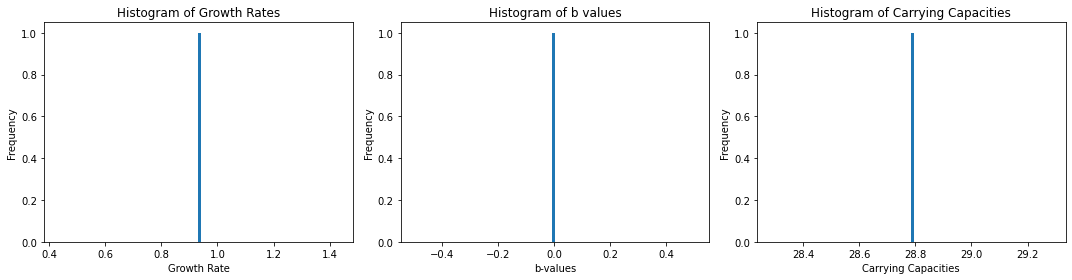

In [11]:
# Plot histograms of growth rates, b-values, and carrying capacities
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.hist(growths, bins=100)
ax1.set_xlabel('Growth Rate')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Growth Rates')

ax2.hist(slopes, bins=100)
ax2.set_xlabel('b-values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of b values')

ax3.hist(capacities, bins=100)
ax3.set_xlabel('Carrying Capacities')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Carrying Capacities')

plt.tight_layout()
plt.show()


In [ ]:
 
# Plot histograms of intercepts/slopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(intercepts, bins=100)
ax1.set_xlabel('Intercept')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Intercepts')

ax2.hist(slopes, bins=100)
ax2.set_xlabel('Slope')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Slopes')

plt.tight_layout()
plt.show()





# Distribute the linear model across multiple processes, parallel


In [ ]:


# Perform a linear model on the pixel data
def linear_trend(array):
    N = array.shape[0]
    X = np.array(list(range(0, 6))).reshape((-1, 1)) #range 0-9 intervals from time-step rasters
    
    # Create empty arrays to store the results
    intercepts = np.empty(N)
    slopes = np.empty(N)
    growths = np.empty(N)
    capacities = np.empty(N)
    r_squared_values = np.empty(N)

    for i in range(N):
        y = array[i, ...]

        # Run linear model
        reg = LinearRegression().fit(X, y)
        # Infer Discrete Population Model Parameters R (Growth Rate) and K (Carrying Capacity) at Nt
        slope = reg.coef_[0]
        intercept = reg.intercept_    # parameter 'a'
        # Calculate growth rate and carrying capacity
        growth_rate = np.exp(intercept)  #intercept that measures density-independent recruitment (r)
        # To estimate K, we made a prediction from our equation at Nt=1 to extract the value of (a+b) and then subtract a to isolate b  

        # Calculate 'b' parameter
        X_pred = np.array([[1]])  # Predicting at Nt = 1
        y_pred = reg.predict(X_pred)
        b = y_pred[0] - intercept

        # Calculate carrying capacity
        if b != 0:
            carrying_capacity = -(intercept / b)
        else:
            carrying_capacity = 1  # Assign a default value when b is zero
      
        # Check if any of the values are extreme, if they are set to low-positive value
        if abs(carrying_capacity) > 100:
            carrying_capacity = 1
    
        # Store the results in the arrays
        intercepts[i] = intercept
        slopes[i] = slope
        growths[i] = growth_rate
        capacities[i] = carrying_capacity

        # Calculate and store the R-squared value
        r_squared = reg.score(X, y)
        r_squared_values[i] = r_squared

    # Return a NumPy array containing the results
    return np.column_stack((intercepts, slopes, growths, capacities, r_squared_values))

print("Linear Trend Analyses")

NUM_PROCESSES = 32

N = prediction_ratio_log_cleaned.shape[0]
P = (NUM_PROCESSES + 1) # Number of breaks (number of partitions + 1)

# Break up the indices into (roughly) equal parts
partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1], np.linspace(0, N, P, dtype=int)[1:]))

# Final range of indices should end +1 past last index for completeness
work = partitions[:-1]
work.append((partitions[-1][0], partitions[-1][1] + 1))

print(work) #shape [(0, 44030), (44030, 88061)]

from concurrent.futures import ProcessPoolExecutor

# Split the master array, base_array, into subarrays defined by the starting and ending indices i and j
with ProcessPoolExecutor(max_workers=NUM_PROCESSES) as executor:
    result = executor.map(linear_trend, [prediction_ratio_log_cleaned[i:j, ...] for i, j in work])

    
regression = list(result)
result = np.concatenate(regression, axis = 0)

#output_array = np.array(result).reshape((446, 1151, 5))

result.shape
# result[0:10, 0] slope
# result[0:10, 1] intercept
# result[0:10, 2] rsquared

print("done")


Linear Trend Analyses
[(0, 2713), (2713, 5427), (5427, 8141), (8141, 10855), (10855, 13568), (13568, 16282), (16282, 18996), (18996, 21710), (21710, 24423), (24423, 27137), (27137, 29851), (29851, 32565), (32565, 35278), (35278, 37992), (37992, 40706), (40706, 43420), (43420, 46133), (46133, 48847), (48847, 51561), (51561, 54275), (54275, 56988), (56988, 59702), (59702, 62416), (62416, 65130), (65130, 67843), (67843, 70557), (70557, 73271), (73271, 75985), (75985, 78698), (78698, 81412), (81412, 84126), (84126, 86841)]



# Plotting and analyses of Intercept, slope, growth rate, carrying capacity, r_squared predictions

(6461,)

(6461,)

(6461,)

(6461,)

(6461,)

Text(0.5, 1.0, 'Intercepts')

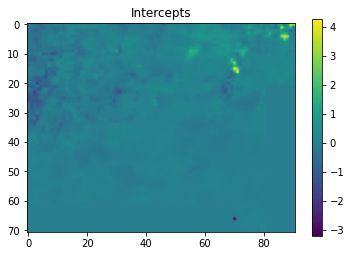

Text(0.5, 1.0, 'Slopes')

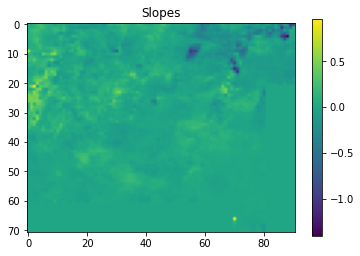

Text(0.5, 1.0, 'R Squared Values')

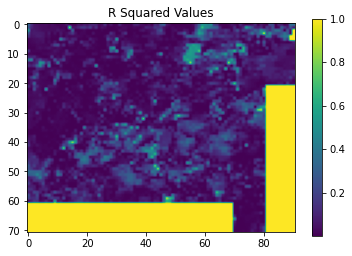

Text(0.5, 1.0, 'Growth Rates')

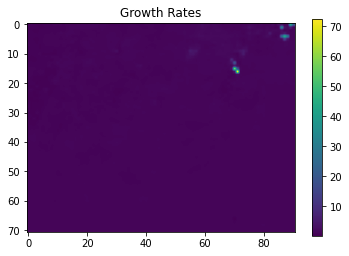

Text(0.5, 1.0, 'Carrying Capacities')

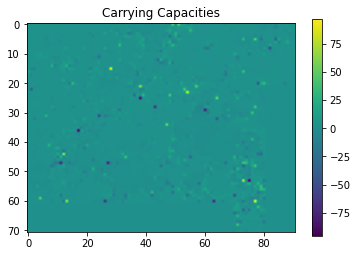

In [13]:

# Convert lists to NumPy arrays
intercepts_arr = np.array(result[..., 0]) #shape (51238815,)
slopes_arr = np.array(result[..., 1])
growths_arr = np.array(result[..., 2])
capacities_arr = np.array(result[..., 3])
r_squared_arr = np.array(result[..., 4])

intercepts_arr.shape
slopes_arr.shape
growths_arr.shape
capacities_arr.shape
r_squared_arr.shape

# Reshape arrays to match the dimensions of the input map
intercepts_arr = intercepts_arr.reshape((71, 91))
slopes_arr = slopes_arr.reshape((71, 91))
growths_arr = growths_arr.reshape((71, 91))
capacities_arr = capacities_arr.reshape((71, 91))
r_squared_arr = r_squared_arr.reshape((71, 91))


# Plotting the intercepts
plt.imshow(intercepts_arr)
plt.colorbar()
plt.title("Intercepts")
plt.show()

# Plotting the slopes
plt.imshow(slopes_arr)
plt.colorbar()
plt.title("Slopes")
plt.show()

# Plotting the carrying capacities
plt.imshow(r_squared_arr)
plt.colorbar()
plt.title("R Squared Values")
plt.show()

# Plotting the growth rates
plt.imshow(growths_arr)
plt.colorbar()
plt.title("Growth Rates")
plt.show()

# Plotting the carrying capacities
plt.imshow(capacities_arr)
plt.colorbar()
plt.title("Carrying Capacities")
plt.show()





# Plot Intercept/Slope distributions, with r2>0.1 

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

# Filter out 0 and 1 values from the coefficient arrays
intercepts_filtered = intercepts_arr.flatten()[(intercepts_arr.flatten() != 0) & (intercepts_arr.flatten() != 1)]
slopes_filtered = slopes_arr.flatten()[(slopes_arr.flatten() != 0) & (slopes_arr.flatten() != 1)]
growths_filtered = growths_arr.flatten()[(growths_arr.flatten() != 0) & (growths_arr.flatten() != 1)]
capacities_filtered = capacities_arr.flatten()[(capacities_arr.flatten() != 0) & (capacities_arr.flatten() != 1)]
r_squared_filtered = r_squared_arr.flatten()[(r_squared_arr.flatten() != 0) & (r_squared_arr.flatten() != 1)]

# Ensure all filtered arrays have the same length
min_length = min(len(intercepts_filtered), len(slopes_filtered), len(growths_filtered), len(capacities_filtered), len(r_squared_filtered))

intercepts_filtered = intercepts_filtered[:min_length]
slopes_filtered = slopes_filtered[:min_length]
growths_filtered = growths_filtered[:min_length]
capacities_filtered = capacities_filtered[:min_length]
r_squared_filtered = r_squared_filtered[:min_length]

# Create a DataFrame with the filtered coefficient arrays
df = pd.DataFrame({
    'Intercept': intercepts_filtered,
    'Slope': slopes_filtered,
    'Growth': growths_filtered,
    'Capacity': capacities_filtered,
    'R-squared': r_squared_filtered
})

# Subset the DataFrame based on the R-squared values
subset_df = df[df['R-squared'] > 0.02]

# Calculate the mean of each coefficient in the subset
mean_intercept = subset_df['Intercept'].mean()
mean_slope = subset_df['Slope'].mean()
mean_growth = subset_df['Growth'].mean()
mean_capacity = subset_df['Capacity'].mean()

# Plot the distributions of the coefficients (both subsets)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Distributions of Coefficients', fontsize=14, y=1.05)

# Distribution of Intercept (subset)
axes[0, 0].hist(subset_df['Intercept'], bins=100)
axes[0, 0].set_title('Intercept (R-squared > 0.2)')

# Distribution of Intercept (no subset)
axes[1, 0].hist(df['Intercept'], bins=100)
axes[1, 0].set_title('Intercept (No subset)')

# Distribution of Slope (subset)
axes[0, 1].hist(subset_df['Slope'], bins=100)
axes[0, 1].set_title('Slope (R-squared > 0.2)')

# Distribution of Slope (no subset)
axes[1, 1].hist(df['Slope'], bins=100)
axes[1, 1].set_title('Slope (No subset)')

# Distribution of Growth (subset)
axes[0, 2].hist(subset_df['Growth'], bins=100)
axes[0, 2].set_title('Growth (R-squared > 0.2)')

# Distribution of Growth (no subset)
axes[1, 2].hist(df['Growth'], bins=100)
axes[1, 2].set_title('Growth (No subset)')

# Distribution of Capacity (subset)
axes[0, 3].hist(subset_df['Capacity'], bins=100)
axes[0, 3].set_title('Capacity (R-squared > 0.2)')

# Distribution of Capacity (no subset)
axes[1, 3].hist(df['Capacity'], bins=100)
axes[1, 3].set_title('Capacity (No subset)')

plt.tight_layout()
plt.show()



# Export .tif results of slope, intercept, r-Squared values from regressions for each pixel in the time-series.

In [ ]:
# Export raster of linear regression coefficients

import rasterio as rio
from rasterio.transform import from_origin



intercepts_arr_out = '/home/moeller/shared/leafy-spurge-demography/Demographic_Ricker_Models/intercept_11km_rickermodel_2001_2019_5timesteps_corrected_august23.tif'
slopes_arr_out = '/home/moeller/shared/leafy-spurge-demography/Demographic_Ricker_Models/slope_11km_rickermodel_2001_2019_5timesteps_corrected_august23.tif'
growths_arr_out = '/home/moeller/shared/leafy-spurge-demography/Demographic_Ricker_Models/growth_r_11km_rickermodel_2001_2019_5timesteps_corrected_august23.tif'
capacities_arr_out = '/home/moeller/shared/leafy-spurge-demography/Demographic_Ricker_Models/carryingcapacity_k_11km_rickermodel_2001_2019_5timesteps_corrected_august23.tif'
r_squared_arr_out = '/home/moeller/shared/leafy-spurge-demography/Demographic_Ricker_Models/rsquared_11km_rickermodel_2001_2019_5timesteps_corrected_august23.tif'

# Output prediction raster
out_meta = src.meta.copy()

# Calculate the new transform to ensure the same resolution as the source data
out_transform = from_origin(src.bounds.left, src.bounds.top, src.res[0]*370, src.res[1]*370) #Modify value (3) to match scaling parameter for linear models run by the block.reduce functioon

# Update output metadata to specify a single band and the new transform
out_meta.update({'driver': 'GTiff',
                  'count': 1,
                  'width': r_squared_arr.shape[1],
                  'height': r_squared_arr.shape[0],
                  'dtype': rio.float32,
                  'crs': src.crs,
                  'transform': out_transform})

# Write the array to a raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(intercepts_arr_out, mode='w', **out_meta) as dst:
        dst.write(intercepts_arr, 1)
        
        
# Write the array to a raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(slopes_arr_out, mode='w', **out_meta) as dst:
        dst.write(slopes_arr, 1)
        

# Write the array to a raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(growths_arr_out, mode='w', **out_meta) as dst:
        dst.write(growths_arr, 1)
        
        
# Write the array to a raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(capacities_arr_out, mode='w', **out_meta) as dst:
        dst.write(capacities_arr, 1)
        
        
# Write the array to a raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(r_squared_arr_out, mode='w', **out_meta) as dst:
        dst.write(r_squared_arr, 1)





# Landsat Gap Filling

In [ ]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt


timeseries_tiles = ['/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1986_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1989_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1992_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1995_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1998_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2001_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2004_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2007_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2010_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2014_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2016_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2019_tile_125_.tif']

stacked_array = np.empty((3715, 3712, 63 * len(timeseries_tiles)), dtype=np.float32)

for i, each_file in enumerate(timeseries_tiles):
    # Open the file, read in as an array
    with rio.open(each_file) as src:
        arr = src.read()
        shp = arr.shape
        print(shp)
        
        # Reshape the input array to match the desired dimensions
        reshaped_arr = np.moveaxis(arr, 0, -1)
        print(reshaped_arr.shape)  # (3715, 3712, 63)
        
        # Stack the arrays along the third axis
        stacked_array[:, :, i * 63:(i + 1) * 63] = reshaped_arr

print(stacked_array.shape)  # (3715, 3712, 756)

print("Done")


# Gap Filling 0s by Mean Value per Band

In [ ]:

# Define the pixel coordinates
pixel_coordinates = (12, 15)

# Extract pixel values for each spectral band
blue_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], ::7]
green_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 1::7]
red_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 2::7]
NIR_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 3::7]
SWIR1_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 4::7]
SWIR2_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 5::7]
NDVI_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 6::7]

# Plot the pixel values
x = range(108)
plt.plot(x, blue_bands, label='Blue')
plt.plot(x, green_bands, label='Green')
plt.plot(x, red_bands, label='Red')
plt.plot(x, NIR_bands, label='NIR')
plt.plot(x, SWIR1_bands, label='SWIR1')
plt.plot(x, SWIR2_bands, label='SWIR2')
plt.plot(x, NDVI_bands, label='NDVI')
plt.xlabel('Year')
plt.ylabel('Pixel Value')
plt.title('Pixel Values for Different Spectral Bands')
plt.legend()
plt.show()


# Replace zero values with the mean of other spectral bands
blue_bands[blue_bands == 0] = np.mean(blue_bands[blue_bands != 0])
green_bands[green_bands == 0] = np.mean(green_bands[green_bands != 0])
red_bands[red_bands == 0] = np.mean(red_bands[red_bands != 0])
NIR_bands[NIR_bands == 0] = np.mean(NIR_bands[NIR_bands != 0])
SWIR1_bands[SWIR1_bands == 0] = np.mean(SWIR1_bands[SWIR1_bands != 0])
SWIR2_bands[SWIR2_bands == 0] = np.mean(SWIR2_bands[SWIR2_bands != 0])
NDVI_bands[NDVI_bands == 0] = np.mean(NDVI_bands[NDVI_bands != 0])

# Plot the pixel values
x = range(108)
plt.plot(x, blue_bands, label='Blue')
plt.plot(x, green_bands, label='Green')
plt.plot(x, red_bands, label='Red')
plt.plot(x, NIR_bands, label='NIR')
plt.plot(x, SWIR1_bands, label='SWIR1')
plt.plot(x, SWIR2_bands, label='SWIR2')
plt.plot(x, NDVI_bands, label='NDVI')
plt.xlabel('Year')
plt.ylabel('Pixel Value')
plt.title('Pixel Values for Different Spectral Bands')
plt.legend()
plt.show()

# Gap Fill one Tile

In [ ]:
import rasterio as rio
import numpy as np

timeseries_tiles = ['/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1986_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1989_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1992_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1995_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1998_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2001_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2004_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2007_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2010_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2014_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2016_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2019_tile_211_.tif']


# Empty array to hold stack of Landsat tiles
stacked_array = None

for i, each_file in enumerate(timeseries_tiles):
    # Open the file, read in as an array
    with rio.open(each_file) as src:
        arr = src.read()
        shp = arr.shape
        print(shp)
        print(f"Read File: {each_file}")

        # Reshape the input array to match the desired dimensions
        reshaped_arr = np.moveaxis(arr, 0, -1)

        if stacked_array is None:
            # Create the stacked array on the first iteration
            stacked_array = np.empty((shp[1], shp[2], 63 * len(timeseries_tiles)), dtype=np.float32)

        # Stack the arrays along the third axis
        stacked_array[:, :, i * 63:(i + 1) * 63] = reshaped_arr

print(stacked_array.shape)  # (3715, 3712, 756)

# Iterate over each pixel
for row in range(stacked_array.shape[0]):
    print(f"Processed row: {row+1}/{stacked_array.shape[0]}")
    for col in range(stacked_array.shape[1]):
        # Extract pixel values for each spectral band
        blue_bands = stacked_array[row, col, ::7]
        green_bands = stacked_array[row, col, 1::7]
        red_bands = stacked_array[row, col, 2::7]
        NIR_bands = stacked_array[row, col, 3::7]
        SWIR1_bands = stacked_array[row, col, 4::7]
        SWIR2_bands = stacked_array[row, col, 5::7]
        NDVI_bands = stacked_array[row, col, 6::7]

        # Replace zero values with the mean of other spectral bands
        blue_bands[blue_bands == 0] = np.mean(blue_bands[blue_bands != 0])
        green_bands[green_bands == 0] = np.mean(green_bands[green_bands != 0])
        red_bands[red_bands == 0] = np.mean(red_bands[red_bands != 0])
        NIR_bands[NIR_bands == 0] = np.mean(NIR_bands[NIR_bands != 0])
        SWIR1_bands[SWIR1_bands == 0] = np.mean(SWIR1_bands[SWIR1_bands != 0])
        SWIR2_bands[SWIR2_bands == 0] = np.mean(SWIR2_bands[SWIR2_bands != 0])
        NDVI_bands[NDVI_bands == 0] = np.mean(NDVI_bands[NDVI_bands != 0])

        # Assign the modified values back to the original array
        stacked_array[row, col, ::7] = blue_bands
        stacked_array[row, col, 1::7] = green_bands
        stacked_array[row, col, 2::7] = red_bands
        stacked_array[row, col, 3::7] = NIR_bands
        stacked_array[row, col, 4::7] = SWIR1_bands
        stacked_array[row, col, 5::7] = SWIR2_bands
        stacked_array[row, col, 6::7] = NDVI_bands

        

print("Done")      
        
#Save raster with rasterio using same metadata as for import
        
        
        

In [ ]:
print(stacked_array.shape)

In [ ]:
import rasterio as rio
from rasterio.transform import from_origin

tile211_timeseries_arr_out = '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_mean_corrected_may1823.tif'

# Output metadata
out_meta = src.meta.copy()

# Calculate the new transform to ensure the same resolution as the source data
out_transform = from_origin(src.bounds.left, src.bounds.top, src.res[0], src.res[1]) 

# Update output metadata to specify a single band and the new transform
out_meta.update({'driver': 'GTiff',
                 'count': stacked_array.shape[2],
                 'width': stacked_array.shape[1],
                 'height': stacked_array.shape[0],
                 'dtype': stacked_array.dtype,
                 'crs': src.crs,
                 'transform': out_transform})

# Write all bands to the same raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(tile211_timeseries_arr_out, mode='w', **out_meta) as dst:
        for i in range(stacked_array.shape[2]):
            dst.write(stacked_array[:, :, i], i + 1)







In [ ]:
#plt.imshow(stacked_array[:, :, 6])
plt.imshow(stacked_array[:, :, 3])
#plt.imshow(stacked_array[:, :, 6])
#plt.imshow(stacked_array[:, :, 6])



# Now with the gap filled Landsat images, load model for prediction

In [ ]:
# Keras setup.
import keras

# Load a trained model
model = keras.models.load_model(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/TemporalCNN_300epochs_latlongenc_dropout_uncertainty_topmodel_apr122023.h5')

model.summary()




# Model Prediction Across Time-Steps 

In [ ]:
#Model Prediction

import rasterio as rio
from rasterio.plot import show
import glob
import time
import itertools
from itertools import tee
import os

# Input prediction .tif path
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_tiny_mean_corrected_may1823.tif'

# Output prediction file path
outpath = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection'

# List all .tif files in /rasters folder for prediction
#tif_image_list = glob.glob(image_path + '*.tif')
#print(tif_image_list[0])

prediction_train_time = time.time()


with rio.open(image_path, 'r') as dataset:
    # First, get the coordinates of every pixel in the .tif image
    print("Read File")
    shape = dataset.shape
    nodata = dataset.nodata
    print(shape)

    # Get the X, Y coordinates (latitude/longitude) for each pixel
    coords = np.empty((shape[0] * shape[1], 2), dtype=np.float64)
    coords[:, 0], coords[:, 1] = dataset.xy(np.repeat(np.arange(shape[0]), shape[1]), np.tile(np.arange(shape[1]), shape[0]))

    # Retrieve the data for each pixel
    data = dataset.read(1).flatten()

    # Filter out pixels with nodata values
    valid_pixels = data != nodata
    coords = coords[valid_pixels]
    data = data[valid_pixels]
    
    coords2 = coords[:,0:2] # Remove 'data' column, make latitude come before longitude
    coords2[:,[1,0]] = coords2[:,[0,1]] # swap longitude and latitude columns
    #print(coords2[1:10, :], coords2.shape)
    print("Got Coordinates of Landsat Image \n")

    # Create a DataFrame with latitude, longitude, and data values
    res = pd.DataFrame({"lat": coords[:, 0], "lon": coords[:, 1], "data": data})

    print(res.head())
    
    # Second, get the spectral data from every pixel in the .tif image
    arr = dataset.read()
    
    bands, width, height = arr.shape
    print(arr.shape)
    
    # Convert Tif Data Type to float32 by division.
    arr = arr/10000
    
    # Loop to process every subset of 63 bands, increasing by 21 bands
    for i in range(0, arr.shape[0], 63):
        subset = arr[i:i+63, :, :]
        print("Processing subset with bands:", i, "-", i+63)
        print(subset.shape)

        # Reshape .tif array axes for correct format so the model can predict
        subset = np.moveaxis(subset, 0, -1)  # move axis to channels last
        new_arr = subset.reshape(-1, subset.shape[-1])  # reshape to row and column
        print(width, height)
        num_pixels = width * height
        spectral = new_arr.reshape(num_pixels, 9, 7)
        print(spectral.shape)

        #combine both latitude/longitude and spectral data into list for model prediction
        X_pred = [coords2, spectral]
        print("Got Spectral Data\n")

        # Predict model and reshape to export.
        p = model.predict(X_pred) # p is prediction from the DL model
        pim = p.reshape(width, height, 10) # Dimension of prediction in rows, columns, bands (10 classes)
        pim2 = np.moveaxis(pim, 2, 0) # move axis so bands is first

        # ArgMax for Segmentation.
        pim3 = np.argmax(pim2, axis=0) # take softmax of predictions for segmentation
        print(pim3.shape)
        
        plt.imshow(pim[..., 9])
        plt.savefig(os.path.join(outpath, f"subset_mini_{i}-{i+63}.png"))

        plt.show()
        
        # Get the file name (landsat_image_170_t.tif) by splitting input path.
        fileout_string = f"tile211_mini_gapcorrected_spurge_tiny_yearly_{i}-{i+63}.tif"

        # Output prediction raster .
        out_meta = dataset.meta.copy()

        # Calculate the new transform with offsets to align with the input data
        out_transform = rio.transform.from_origin(dataset.bounds.left + 1000, dataset.bounds.top - 500, dataset.res[0], dataset.res[1])

        # Update output metadata with the new transform
        out_meta.update({'driver': 'GTiff',
                         'width': subset.shape[1],
                         'height': subset.shape[0],
                         'count': 1,
                         'dtype': 'float64',
                         'crs': dataset.crs,
                         'transform': out_transform,
                         'nodata': 0})


        # Write predicted raster to file.
        with rio.open(fp=os.path.join(outpath, "prediction_" + fileout_string), mode='w', **out_meta) as dst:
            dst.write(pim[:, :, 9], 1) # to export one layer, write individual bands
            #dst.write(pim3, 1) # the number one is the number of bands

        print(f"Writing file {fileout_string}")
        prediction_time = round(time.time()-prediction_train_time, 2)
        print(prediction_time)


# Save time-series of png images predictions as an animated-gif

In [ ]:
#Save tiles as png images
import os
import imageio
from PIL import Image

# Directory containing the PNG images
image_directory = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/'

# Output directory and file name for the animated GIF
output_directory =  r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/'
gif_filename = 'animated.gif'

png_files = glob.glob(image_directory + '*.png')

# Sort the list of PNG files in increasing order
sorted_png_files = sorted(png_files, key=lambda x: int(x.split("_")[-1].split("-")[0]))

# Update the png_files variable with the sorted list
png_files = sorted_png_files

print(png_files)


# Create the animated GIF using imageio
with imageio.get_writer(os.path.join(output_directory, gif_filename), mode='I') as writer:
    for png_file in png_files:
        image_path = os.path.join(image_directory, png_file)
        image = Image.open(image_path)
        image_array = np.array(image)
        writer.append_data(image_array)

print(f"Animated GIF saved as {os.path.join(output_directory, gif_filename)}")



# Linear regression rasters for analyses of population trends.

Result array holds the slope/intercept/rsqaured values

Base_Array holds the year and prediction values

In [ ]:

#Read in the slope, intercept, and r-squared raster .tif files

slope_raster = r'/home/moeller/shared/leafy-spurge-demography/timeseries_linearmodels_prediction_mosaics_topmodel/timeseries_linear_models_slopes_mosaic_output_scaling10_300m.tif'

intercept_raster = r'/home/moeller/shared/leafy-spurge-demography/timeseries_linearmodels_prediction_mosaics_topmodel/timeseries_linear_models_intercepts_mosaic_output_scaling10_300m.tif'

rsquared_raster = r'/home/moeller/shared/leafy-spurge-demography/timeseries_linearmodels_prediction_mosaics_topmodel/timeseries_linear_models_rsquared_mosaic_output_scaling10_300m.tif'


# Open the file, read in as an array
#with rio.open(slope_raster) as src:
#    slope_arr = src.read(1)
#    shp =  slope_arr.shape
#    print(shp)
    

# Open the file, read in as an array
#with rio.open(intercept_raster) as src:
#    slope_arr = src.read(1)
#    shp =  slope_arr.shape
#    print(shp)
    

# Open the file, read in as an array
#with rio.open(rsquared_raster) as src:
#    slope_arr = src.read(1)
#    shp =  slope_arr.shape
#    print(shp)



# Reshape regression results to match dimensions of input .tif rasters

In [ ]:


# Subset the intercept, slope, rsquared values from the resulting linear models in the 'result' array
intercept_array = np.array(result[..., 1]).reshape((446, 1151)) #change to reflect raster dimensions after block_reduce

slope_array = np.array(result[..., 0]).reshape((446, 1151)) #change to reflect raster dimensions after block_reduce

rsquared_array = np.array(result[..., 2]).reshape((446, 1151))

base_array_reshape = base_array.reshape((446, 1151, 10, 2))

# Display one raster to verify it's correct
plt.imshow(slope_array)


# Data Exploration of Slope, Intercept regression coefficients for the time-series analyses.

In [ ]:

import numpy as np

# Result array holds the slope/intercept values
#intercept_array = np.array(result[..., 0]).reshape((446, 1151))
#slope_array = np.array(result[..., 1]).reshape((446, 1151))

# Calculate summary statistics for intercept, slope, rsquared arrays
intercept_mean = np.mean(intercepts_arr)
intercept_median = np.median(intercepts_arr)
intercept_std = np.std(intercepts_arr)
intercept_min = np.min(intercepts_arr)
intercept_max = np.max(intercepts_arr)

slope_mean = np.mean(slopes_arr)
slope_median = np.median(slopes_arr)
slope_std = np.std(slopes_arr)
slope_min = np.min(slopes_arr)
slope_max = np.max(slopes_arr)

# Print out the summary statistics
print("Intercept summary statistics:")
print(f"Intercept mean: {intercept_mean:.2f}")
print(f"Intercept median: {intercept_median:.2f}")
print(f"Intercept standard deviation: {intercept_std:.2f}")
print(f"Intercept minimum: {intercept_min:.2f}")
print(f"Intercept maximum: {intercept_max:.2f}")

print("Slope summary statistics:")
print(f"Slope mean: {slope_mean:.2f}")
print(f"Slope standard deviation: {slope_std:.2f}")
print(f"Slope minimum: {slope_min:.2f}")
print(f"Slope maximum: {slope_max:.2f}")





In [ ]:
import seaborn as sns

# Create a heatmap of the slope values
sns.heatmap(slopes_arr, cmap="coolwarm", center=0)
plt.title("Slope values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

sns.heatmap(intercepts_arr, cmap="coolwarm", center=0)
plt.title("Intercept values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

sns.heatmap(r_squared_arr, cmap="coolwarm", center=0)
plt.title("Rsquared values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

sns.heatmap(growths_arr, cmap="coolwarm", center=0)
plt.title("Growth Rate (r) values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

sns.heatmap(capacities_arr, cmap="coolwarm", center=0)
plt.title("Carrying Capacity (K) values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()


In [ ]:
# Linear Model Prediction Plotting

import seaborn as sns

# Get the slope and intercept values
slope_values = slope_array.ravel()
intercept_values = intercept_array.ravel()
rsquared_values = rsquared_array.ravel()

# Create a KDE plot for slope values
sns.kdeplot(slope_values)
plt.title("Distribution of Slope Values")
plt.xlabel("Slope")
plt.ylabel("Density")
plt.show()

# Create a KDE plot for intercept values
sns.kdeplot(intercept_values)
plt.title("Distribution of Intercept Values")
plt.xlabel("Intercept")
plt.ylabel("Density")
plt.show()

# Create a KDE plot for intercept values
sns.kdeplot(rsquared_values)
plt.title("Distribution of Rsquared Values")
plt.xlabel("Rsquared")
plt.ylabel("Density")
plt.show()



# Select and Plot linear regressions for pixels


In [ ]:
import matplotlib.pyplot as plt
import os

output_directory = r'/home/moeller/shared/leafy-spurge-demography/model_predictions/spurge_mosaic_predictions_gapcorrected_july2023/ricker_model_linear_regression_plots_pixels'

# Plot linear model for each pixel
for i in range(base_array_reshape.shape[0]):
    for j in range(base_array_reshape.shape[1]):
        if slopes_arr[i, j] > 0:
            x = base_array_reshape[i, j, :, 0] # years
            y = base_array_reshape[i, j, :, 1] # predictions
            slope = slopes_arr[i, j]
            intercept = intercepts_arr[i, j]
            fig, ax = plt.subplots()
            ax.scatter(x, y)
            ax.plot(x, slope*x + intercept, color='red')
            ax.set_xlabel('Year')
            ax.set_ylabel('Predicted Probability')
            ax.set_title(f'Pixel ({i}, {j}): y = {slope:.2f}x + {intercept:.2f}')
            plt.show()
                #output_filename = os.path.join(output_directory, f'predicted_spurge_timeseries_linearmodel_pixel_{i}_{j}.png')  # Specify the output filename
                #plt.savefig(output_filename)  # Save the plot as a .png image
                #plt.close(fig)  # Close the figure to free up memory


In [ ]:

#Select and plot single pixel time-series 

import matplotlib.pyplot as plt
import os

output_directory = r'/home/moeller/shared/leafy-spurge-demography/timeseries_linearmodels_prediction_mosaics_topmodel/linear_model_plots'

#select pixel of group of pixels
i = 0
j = 0

x = base_array_reshape[i, j, :, 0] # years
y = base_array_reshape[i, j, :, 1] # predictions
slope = slope_array[i, j]
intercept = intercept_array[i, j]
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, slope*x + intercept, color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Predicted Probability')
ax.set_title(f'Pixel ({i}, {j}): y = {slope:.2f}x + {intercept:.2f}')
plt.show()

print(x)
print(y)


In [ ]:
# Fit a Ricker model to slope data

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ricker(t, N0, r, K):
    return N0 * np.exp(r * (1 - N0 / K) * t)

# Prepare your time-series data
i = 86
j = 495

t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Time points
N_observed = np.array([ 6231.7108, 36181.8709, 21075.5995, 39831.1248, 48051.8396, 49414.467, 41328.7485, 50371.4437, 45313.7804, 49931.2288])
#N_observed = base_array_reshape[i, j, :, 1]  # Observed population values

print(N_observed)

# Fit the Ricker model to the data with modified arguments
popt, pcov = curve_fit(ricker, t, N_observed, maxfev=10000)

# Extract the fitted parameters
N0_fit, r_fit, K_fit = popt

# Generate the predicted population values using the fitted parameters
N_predicted = ricker(t, N0_fit, r_fit, K_fit)

# Plot the observed and predicted population values
plt.plot(t, N_observed, 'bo', label='Observed')
plt.plot(t, N_predicted, 'r-', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted parameters:\nN0: {N0_fit:.3f}\nr: {r_fit:.3f}\nK: {K_fit:.3f}")




# Principal Compoonents Analyses and Correlation analyses between climate and topographic variables, for leafy spurge predictions (probability) and population change (slopes)

In [ ]:


# Find the index with the highest positive slope
max_positive_slope_index = np.unravel_index(np.argmax(slope_array), slope_array.shape)
max_positive_slope_i, max_positive_slope_j = max_positive_slope_index

# Find the index with the highest negative slope
max_negative_slope_index = np.unravel_index(np.argmin(slope_array), slope_array.shape)
max_negative_slope_i, max_negative_slope_j = max_negative_slope_index

# Plot the pixels with the highest positive and negative slope values
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the highest positive slope
axes[0].scatter(base_array_reshape[max_positive_slope_i, max_positive_slope_j, :, 0], 
                base_array_reshape[max_positive_slope_i, max_positive_slope_j, :, 1])
axes[0].plot(base_array_reshape[max_positive_slope_i, max_positive_slope_j, :, 0],
             slope_array[max_positive_slope_i, max_positive_slope_j] * base_array_reshape[max_positive_slope_i, max_positive_slope_j, :, 0] + intercept_array[max_positive_slope_i, max_positive_slope_j],
             color='red')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Predicted Probability')
axes[0].set_title(f'Pixel ({max_positive_slope_i}, {max_positive_slope_j}): Highest Positive Slope')

# Plot for the highest negative slope
axes[1].scatter(base_array_reshape[max_negative_slope_i, max_negative_slope_j, :, 0], 
                base_array_reshape[max_negative_slope_i, max_negative_slope_j, :, 1])
axes[1].plot(base_array_reshape[max_negative_slope_i, max_negative_slope_j, :, 0],
             slope_array[max_negative_slope_i, max_negative_slope_j] * base_array_reshape[max_negative_slope_i, max_negative_slope_j, :, 0] + intercept_array[max_negative_slope_i, max_negative_slope_j],
             color='red')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Predicted Probability')
axes[1].set_title(f'Pixel ({max_negative_slope_i}, {max_negative_slope_j}): Highest Negative Slope')

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Find the index with the lowest R-squared value
lowest_rsquared_index = np.unravel_index(np.argmin(rsquared_array), rsquared_array.shape)
lowest_rsquared_i, lowest_rsquared_j = lowest_rsquared_index

# Plot the pixel with the lowest R-squared value
plt.scatter(base_array_reshape[lowest_rsquared_i, lowest_rsquared_j, :, 0], 
            base_array_reshape[lowest_rsquared_i, lowest_rsquared_j, :, 1])
plt.plot(base_array_reshape[lowest_rsquared_i, lowest_rsquared_j, :, 0],
         slope_array[lowest_rsquared_i, lowest_rsquared_j] * base_array_reshape[lowest_rsquared_i, lowest_rsquared_j, :, 0] + intercept_array[lowest_rsquared_i, lowest_rsquared_j],
         color='red')
plt.xlabel('Year')
plt.ylabel('Predicted Probability')
plt.title(f'Pixel ({lowest_rsquared_i}, {lowest_rsquared_j}): Lowest R-squared')

plt.show()




# Find the index with the highest R-squared value
highest_rsquared_index = np.unravel_index(np.argmax(rsquared_array), rsquared_array.shape)
highest_rsquared_i, highest_rsquared_j = highest_rsquared_index

# Plot the pixel with the highest R-squared value
plt.scatter(base_array_reshape[highest_rsquared_i, highest_rsquared_j, :, 0], 
            base_array_reshape[highest_rsquared_i, highest_rsquared_j, :, 1])
plt.plot(base_array_reshape[highest_rsquared_i, highest_rsquared_j, :, 0],
         slope_array[highest_rsquared_i, highest_rsquared_j] * base_array_reshape[highest_rsquared_i, highest_rsquared_j, :, 0] + intercept_array[highest_rsquared_i, highest_rsquared_j],
         color='red')
plt.xlabel('Year')
plt.ylabel('Predicted Probability')
plt.title(f'Pixel ({highest_rsquared_i}, {highest_rsquared_j}): Highest R-squared')

plt.show()




In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_csv(r'/home/moeller/shared/leafy-spurge-demography/Leafy_Spurge_PCA_Predicted_Climate_EnvVarbs.csv')

predictors = data.iloc[:, 4:]  # Exclude the first 4 columns (predicted value, slope, intercept, rsquared) and keep only environmental predictors
print(predictors.shape)

response = data.iloc[:, 2]  # response (predicted value of leafy spurge from 2019 model, slope, intercept, etc)
print(response.shape)

#predictors.head
#response.head

# Calculate the correlation matrix
correlation_matrix = predictors.corr()

# Calculate the correlation coefficients
correlation_coeffs = predictors.corrwith(response)
print(correlation_coeffs)

# Plot scatter plots of predictor variables and response
for column in predictors.columns:
    fig, ax = plt.subplots()
    ax.scatter(predictors[column], response)
    ax.set_xlabel(column)
    ax.set_ylabel('Response')
    ax.set_title(f'{column} vs. Response')
    plt.show()

# Plot correlation matrix as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(correlation_matrix, cmap='coolwarm')
ax.set_xticks(range(len(predictors.columns)))
ax.set_yticks(range(len(predictors.columns)))
ax.set_xticklabels(predictors.columns, rotation=90)
ax.set_yticklabels(predictors.columns)
plt.colorbar(heatmap)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

data = pd.read_csv(r'/home/moeller/shared/leafy-spurge-demography/Leafy_Spurge_PCA_Predicted_Climate_EnvVarbs.csv')

predictors = data.iloc[:, 4:]  # Exclude the first 4 columns (predicted value, slope, intercept, rsquared) and keep only environmental predictors
print(predictors.shape)

response = data.iloc[:, 1]  # response (predicted value of leafy spurge from 2019 model, slope, intercept, etc)
print(response.shape)

# Standardize the predictor variables
scaler = StandardScaler()
predictors_standardized = scaler.fit_transform(predictors)

# Perform PCA
pca = PCA()
pca.fit(predictors_standardized)

# Access the principal components
principal_components = pca.transform(predictors_standardized)

# Calculate the correlation between each principal component and the response variable
correlations = []
for i in range(principal_components.shape[1]):
    corr, _ = pearsonr(principal_components[:, i], response)
    correlations.append(corr)

# Print the correlations
print("Correlation between principal components and response variable:")
for i, corr in enumerate(correlations):
    print(f"Principal Component {i+1}: {corr:.2f}")

# Calculate the residuals
reconstructed_data = scaler.inverse_transform(pca.inverse_transform(principal_components))
residuals = response - reconstructed_data[:, 0]

# Perform residual analysis (e.g., plot residuals, calculate summary statistics)
# For example, to plot the residuals:
import matplotlib.pyplot as plt

plt.scatter(range(len(residuals)), residuals)
plt.xlabel("Sample Index")
plt.ylabel("Residuals")
plt.title("Residuals Analysis")
plt.show()



In [ ]:

#Plot Landsat Imagery by Tiles and Band RGB Composites

import rasterio
import matplotlib.pyplot as plt

image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1992_tile_125_.tif'

# Load the multiband image using rasterio
with rasterio.open(image_path) as src:
    # Read the image as a numpy array
    img_array = src.read()
    img_array.shape

    # Convert the image to a three band RGB composite
    rgb = img_array[11:14, :, :].transpose(1, 2, 0)
    rgb.shape

# Display the RGB composite using matplotlib
plt.imshow(rgb)
plt.show()


#plt.savefig('leafy_spurge_softmax_predictions_2019.png', dpi=300)



# Other Helpful Functions


# Clip raster by shapefile



In [ ]:

import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask    
    
    
    
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1986_tile_125_.tif'

output_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection_tiny/landsat_image_temporalcnn_1986_tile_125_tiny_.tif'

# Open the raster file and read its metadata
with rasterio.open(image_path) as src:
    meta = src.meta

# Open the shapefile
shp = gpd.read_file(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/shapefiles/small_bbox_tile125.shp') #Shapefile must be in EPSG 4326

# Extract the geometry of the shapefile
geom = shp.geometry

# Clip the raster using the shapefile
with rasterio.open(image_path) as src:
    out_image, out_transform = mask(src, geom, crop=True)

# Update the metadata of the clipped raster
meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform})

# Write the clipped raster to a new file
with rasterio.open(output_path, "w", **meta) as dst:
    dst.write(out_image)

    
    

# Reproject Landsat/.TIF raster based on new ESPG

In [ ]:

import rasterio
from rasterio.warp import calculate_default_transform, reproject

image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1989_tile_125_.tif'

output_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1989_tile_125_reproj_.tif'


# Open the source raster file
with rasterio.open(image_path) as src:
    print(src.crs)
    # Define the target CRS
    dst_crs = 'EPSG:3857'
    # Define the dimensions and resolution of the output raster
    dst_transform, dst_width, dst_height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    dst_profile = src.profile.copy()
    dst_profile.update({'crs': dst_crs, 'transform': dst_transform, 'width': dst_width, 'height': dst_height})
    # Reproject the raster file
    with rasterio.open(output_path, 'w', **dst_profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=rasterio.warp.Resampling.bilinear,
                num_threads=4
            )


            